<a href="https://colab.research.google.com/github/pul35/Stock_market_forecasting/blob/main/stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import stock data
import time
import datetime
from datetime import date
import pandas as pd

today = date.today()
year =int(today.strftime("%Y"))
month = int(today.strftime("%m"))
day = int(today.strftime("%d"))


ticker = 'VOLCAR-B'
period1 = int(time.mktime(datetime.datetime(2021, 10, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(year, month, day, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}.ST?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

sd = pd.read_csv(query_string) #Stock data
#df.to_csv('AAPL.csv')
sd.tail()

 

,Date,Open,High,Low,Close,Adj Close,Volume
116,2022-04-14,68.519997,68.910004,67.239998,68.910004,68.910004,1027732
117,2022-04-19,67.459999,70.879997,66.699997,70.730003,70.730003,2654840
118,2022-04-20,69.650002,71.279999,69.000000,69.000000,69.000000,1634748
119,2022-04-21,68.750000,71.169998,65.709999,71.169998,71.169998,4404713
120,2022-04-22,70.000000,70.680000,68.320000,68.910004,68.910004,1435296


<Figure size 432x288 with 0 Axes>

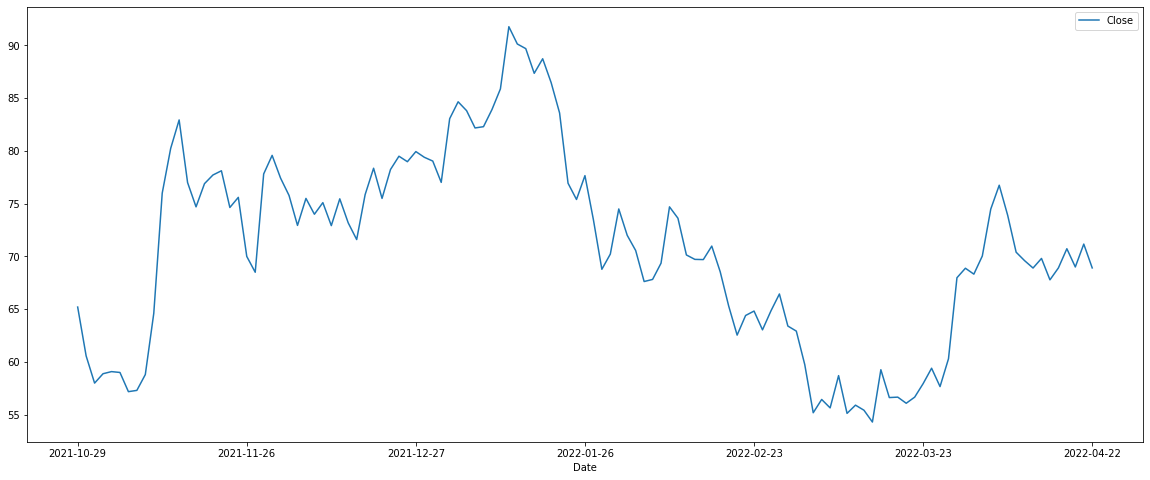

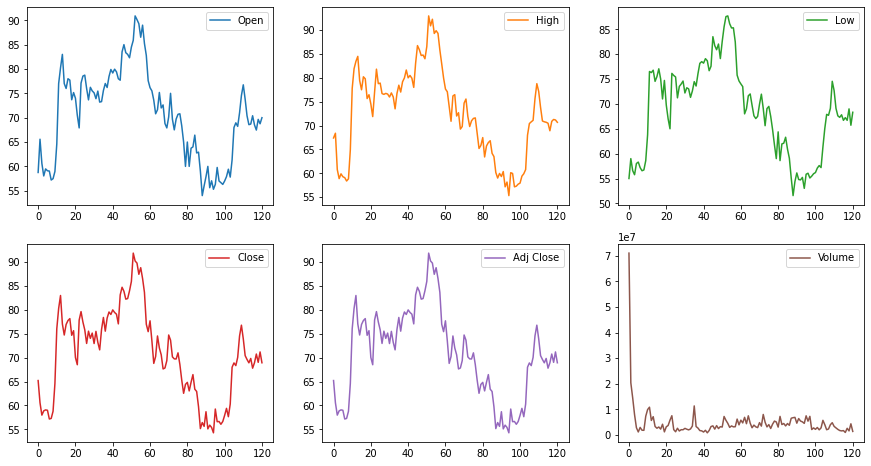

In [15]:
# Plot stock data

import matplotlib.pyplot as plt

plt.figure()
sd.plot(x = 'Date', y = 'Close', figsize=(20,8), x_compat=True)

sd.plot(subplots=True, layout=(2, 3), figsize=(15, 8), sharex=False);



In [16]:
# Pre processing data


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Scaling data between [0 ,1]

sd_close = sd.reset_index()['Close']
print(sd_close)

scaler = MinMaxScaler(feature_range=(0,1))
sd_close = scaler.fit_transform(np.array(sd_close).reshape(-1,1))

# Splitting data set into train data & test data

ratio = 0.80        #Splitting ratio
train_size = round(len(sd_close) * ratio)
train_data, test_data = sd_close[0:train_size, :], sd_close[train_size:len(sd_close), :]

#print(test_data.shape)

# CREATE DATA SET WITH TIMESTEP
# ex: X = t, t+1, t+3      Y = t+4

def create_dataset(data, timestep):
  data_X = []
  data_Y =[]
  for i in range(len(data)-timestep):
    a= data[i: (i+timestep),0]
    b = data[i+timestep, 0]
    data_X.append([a])
    data_Y.append(b)
  return np.array(data_X), np.array(data_Y)





0      65.199997
1      60.570000
2      57.990002
3      58.880001
4      59.080002
         ...    
116    68.910004
117    70.730003
118    69.000000
119    71.169998
120    68.910004
Name: Close, Length: 121, dtype: float64


In [17]:
# Generate data to feed into the model

timestep = 3
X_train, Y_train = create_dataset(train_data, timestep)
X_test, Y_test = create_dataset(test_data, timestep)

print(Y_train.shape)
print(Y_test.shape)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], 1)

#print(X_test)
#print(X_train)


(94,)
(21,)


In [18]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

#model1 = Sequential()
#model1.add(InputLayer(input_shape = (timestep, 1)))
#model1.add(LSTM(64))
#model1.add(Dense(8, 'relu'))
#model1.add(Dense(1, 'linear'))
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(timestep,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()






Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 3, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
#cp1 = ModelCheckpoint('model1/', save_best_only=True)
#model1.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 500)

Epoch 1/500
3/3 [==============================] - 7s 648ms/step - loss: 0.2765 - val_loss: 0.1321
Epoch 2/500
3/3 [==============================] - 0s 21ms/step - loss: 0.2440 - val_loss: 0.1101
Epoch 3/500
3/3 [==============================] - 0s 21ms/step - loss: 0.2093 - val_loss: 0.0863
Epoch 4/500
3/3 [==============================] - 0s 21ms/step - loss: 0.1734 - val_loss: 0.0608
Epoch 5/500
3/3 [==============================] - 0s 22ms/step - loss: 0.1308 - val_loss: 0.0354
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0843 - val_loss: 0.0156
Epoch 7/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0487 - val_loss: 0.0118
Epoch 8/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0313 - val_loss: 0.0319
Epoch 9/500
3/3 [==============================] - 0s 19ms/step - loss: 0.0460 - val_loss: 0.0446
Epoch 10/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0483 - val_loss: 0.0308
Epoch 11/500
3/3 [

In [20]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)



In [21]:
# Inverse transform predictions

trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,trainPredict))

print(trainPredict.shape)
print(testPredict.shape)


(94, 1)
(21, 1)


<Figure size 432x288 with 0 Axes>

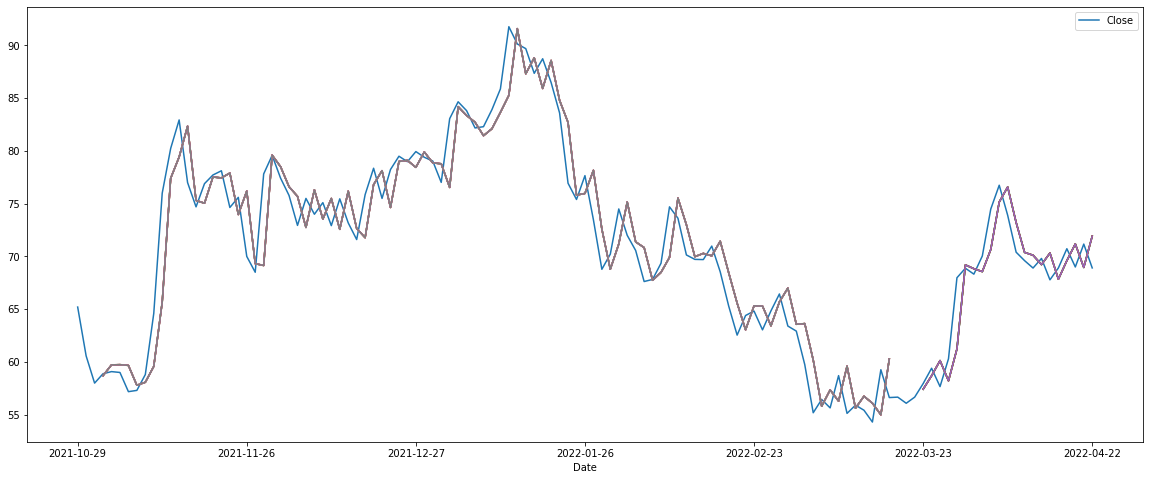

In [22]:
#Plot


plt.figure()
sd.plot(x = 'Date', y = 'Close', figsize=(20,8), x_compat=True)

### Plotting 
# shift train predictions for plotting
look_back= timestep
trainPredictPlot = np.empty_like(sd)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
plt.plot(trainPredictPlot)
# shift test predictions for plotting
testPredictPlot = np.empty_like(sd)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(2*look_back):len(sd_close), :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(sd))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.show()


In [23]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: ignored

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from utils import data_string_to_float, status_calc


# The percentage by which a stock has to beat the S&P500 to be considered a 'buy'
OUTPERFORMANCE = 10


def build_data_set():
    """
    Reads the keystats.csv file and prepares it for scikit-learn
    :return: X_train and y_train numpy arrays
    """
    training_data = pd.read_csv("keystats.csv", index_col="Date")
    training_data.dropna(axis=0, how="any", inplace=True)
    features = training_data.columns[6:]

    X_train = training_data[features].values
    # Generate the labels: '1' if a stock beats the S&P500 by more than 10%, else '0'.
    y_train = list(
        status_calc(
            training_data["stock_p_change"],
            training_data["SP500_p_change"],
            OUTPERFORMANCE,
        )
    )

    return X_train, y_train


def predict_stocks():
    X_train, y_train = build_data_set()
    # Remove the random_state parameter to generate actual predictions
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # Now we get the actual data from which we want to generate predictions.
    data = pd.read_csv("forward_sample.csv", index_col="Date")
    data.dropna(axis=0, how="any", inplace=True)
    features = data.columns[6:]
    X_test = data[features].values
    z = data["Ticker"].values

    # Get the predicted tickers
    y_pred = clf.predict(X_test)
    if sum(y_pred) == 0:
        print("No stocks predicted!")
    else:
        invest_list = z[y_pred].tolist()
        print(
            f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
        print(" ".join(invest_list))
        return invest_list


if __name__ == "__main__":
    print("Building dataset and predicting stocks...")
    predict_stocks()


In [ ]:
import numpy as np

s = np.arange(10) [slice(0, 3)]


print(s)